https://thinkingneuron.com/how-to-classify-text-using-word2vec/


Google Word Vectors:
https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?pli=1&resourcekey=0-wjGZdNAUop6WykTtMip30g

In [11]:
!python3 -m pip install -U gensim

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [12]:
from gensim.models import Word2Vec
from gensim.models import FastText
import re

from sklearn.decomposition import PCA

from matplotlib import pyplot as plt
# import plotly.graph_objects as go

import warnings

from sklearn.datasets import fetch_20newsgroups
from sklearn.naive_bayes import MultinomialNB

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import numpy as np

# ------------------------------------------------------------


warnings.filterwarnings('ignore')


<BarContainer object of 8 artists>

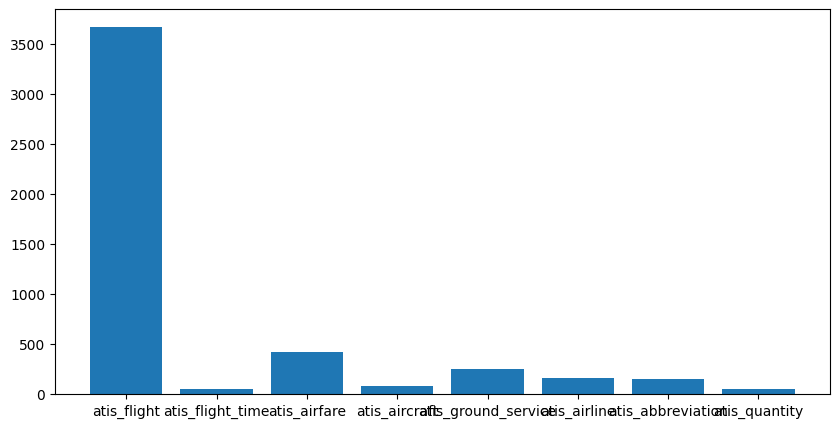

In [13]:
import pandas as pd

train_df = pd.read_csv('atis_intents_train.csv', names=['intent','text'])

x = train_df['intent'].drop_duplicates()
y = [len(train_df[train_df['intent'] == intent]) for intent in x]
y = []
for intent in x:
  y.append(len(train_df[train_df['intent'] == intent]))

plt.figure(figsize=(10,5))
plt.bar(x,y)



1145

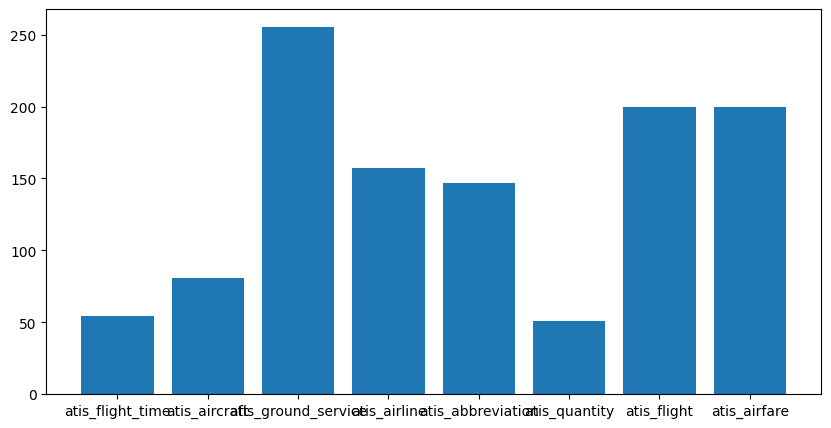

In [14]:

reduced_flight = train_df[train_df['intent'] == 'atis_flight'][:200]
train_df = train_df[train_df['intent'] != 'atis_flight']
train_df = pd.concat([train_df,reduced_flight], axis=0)
train_df[train_df['intent'] == 'atis_flight']


reduced_airfare = train_df[train_df['intent'] == 'atis_airfare'][:200]
train_df = train_df[train_df['intent'] != 'atis_airfare']
train_df = pd.concat([train_df,reduced_airfare], axis=0)
train_df[train_df['intent'] == 'atis_airfare']


x = train_df['intent'].drop_duplicates()
y = [len(train_df[train_df['intent'] == intent]) for intent in x]
y = []
for intent in x:
  y.append(len(train_df[train_df['intent'] == intent]))

plt.figure(figsize=(10,5))
plt.bar(x,y)

len(train_df)

In [15]:
clean_text = []
for text in train_df['text']:
   clean = text.lower()

   #remove punctuation
   clean = re.sub('[^a-zA-Z]', ' ', clean)

   #remove tags
   clean = re.sub("&lt;/?.*?&gt;", " &lt;&gt; ", clean)

   #remove digits and special chars
   clean = re.sub("(\\d|\\W)+", " ", clean)
   clean_text.append(clean)

train_df['clean'] = clean_text
train_df.head()

,intent,text,clean
2,atis_flight_time,what is the arrival time in san francisco for...,what is the arrival time in san francisco for...
6,atis_aircraft,what kind of aircraft is used on a flight fro...,what kind of aircraft is used on a flight fro...
9,atis_ground_service,what kind of ground transportation is availab...,what kind of ground transportation is availab...
15,atis_ground_service,show me the ground transportation in denver,show me the ground transportation in denver
22,atis_aircraft,what kinds of planes are used by american air...,what kinds of planes are used by american air...


In [120]:
for i in range(len(train_df.index)):
    if train_df.iloc[i]['text'] != train_df.iloc[i]['clean']:
        print(train_df.iloc[i]['text'], '\n', train_df.iloc[i]['clean'])

 what is the arrival time in san francisco for the 755 am flight leaving washington 
  what is the arrival time in san francisco for the am flight leaving washington
 on the 8 am flight from san francisco to atlanta what type of aircraft is used 
  on the am flight from san francisco to atlanta what type of aircraft is used
 what's the difference between fare code q and fare code f 
  what s the difference between fare code q and fare code f
 list the number of flights leaving boston for dallas fort worth before 9 am in the morning 
  list the number of flights leaving boston for dallas fort worth before am in the morning
 what is the flight schedule of the f28 from pittsburgh to baltimore 
  what is the flight schedule of the f from pittsburgh to baltimore
 i need ground transportation in dallas please show me what's available 
  i need ground transportation in dallas please show me what s available
 what's fare code yn 
  what s fare code yn
 how many stops on continental 1765 from b

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

# Ticket Data
corpus = train_df['clean']

# Creating the vectorizer
vectorizer = CountVectorizer(stop_words='english')

# Converting the text to numeric data
X = vectorizer.fit_transform(corpus)

# print(vectorizer.get_feature_names())


CountVectorizedData = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
CountVectorizedData['Intent'] = train_df['intent']
print(CountVectorizedData.shape)
CountVectorizedData.head()

(1145, 385)


,aa,abbreviation,abbreviations,ac,advertises,afternoon,air,aircraft,airfare,airline,...,week,weekday,weekdays,west,westchester,worth,yn,york,yyz,Intent
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,atis_flight
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,atis_flight
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,atis_flight_time
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,atis_airfare
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,atis_airfare


In [17]:
import gensim
#Loading the word vectors from Google trained word2Vec model
GoogleModel = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

In [19]:
WordsVocab = CountVectorizedData.columns[:-1]
WordsVocab[:10]

Index(['aa', 'abbreviation', 'abbreviations', 'ac', 'advertises', 'afternoon',
       'air', 'aircraft', 'airfare', 'airline'],
      dtype='object')

In [20]:
def corpus_to_vecs(text):
    # Converting the text to numeric data
    X = vectorizer.transform(text)
    CountVecData=pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names())
    
    # Creating empty dataframe to hold sentences
    w2vec_data = pd.DataFrame()
    
    # Looping through each row for the data
    for i in range(CountVecData.shape[0]):

        # initiating a sentence with all zeros
        sentence = np.zeros(300)

        # Looping thru each word in the sentence and if its present in 
        # the Word2Vec model then storing its vector
        for word in WordsVocab[CountVecData.iloc[i,:]>=1]:
            #print(word)
            if word in GoogleModel.key_to_index.keys():    
                sentence += GoogleModel[word]
        # Appending the sentence to the dataframe
        w2vec_data=w2vec_data.append(pd.DataFrame([sentence]))
    return(w2vec_data)



    

word2vec_data = corpus_to_vecs(train_df['clean'])

In [21]:
print(word2vec_data.shape, CountVectorizedData.shape)

(1145, 300) (1145, 385)


In [22]:
# Adding the target variable
word2vec_data.reset_index(inplace=True, drop=True)
word2vec_data['Intent'] = CountVectorizedData['Intent']
 
# Assigning to DataForML variable
DataForML = word2vec_data
DataForML.dropna()

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,Intent
0,-0.121582,0.939209,-0.221008,0.315430,-0.037790,-0.536011,-0.911621,-1.098022,0.528748,0.464661,...,0.491390,0.183594,0.476685,1.004395,-0.418945,-1.130127,-0.492325,-0.227783,-0.015015,atis_flight
1,0.047119,0.545410,0.334961,1.017700,-0.344238,-0.550049,-0.583008,-1.340820,0.741119,-0.074829,...,0.499939,0.356201,0.378967,-0.006226,-0.538574,-0.477051,0.375000,-0.010681,-0.237183,atis_flight
2,-0.153931,-0.567627,0.027832,0.754395,-0.680908,-0.381836,0.126953,-0.463379,0.513885,0.027466,...,-0.286255,0.351562,0.423950,0.582764,0.062500,-0.103394,-0.399292,0.189026,0.270874,atis_flight_time
3,-0.224731,-0.392578,0.174561,0.211426,-0.314697,-0.419434,-0.286133,-0.271484,0.094971,-0.061035,...,-0.174438,0.379883,0.268555,0.439209,-0.098633,-0.190308,-0.290405,0.157715,0.401855,atis_airfare
4,0.475403,0.219238,0.639632,1.523926,-1.023438,-0.843750,-0.484497,-0.131836,0.780640,-0.113586,...,-0.404602,0.333008,0.337097,0.148926,-0.209961,-0.105957,0.458984,0.280701,-0.363770,atis_airfare
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1124,0.203857,0.637085,0.016357,0.670654,-0.061035,-0.250732,-1.029297,-0.201904,0.157257,0.025757,...,-0.133545,-0.000854,0.453491,0.790527,0.114563,-0.343262,-0.226807,1.211639,-0.605225,atis_ground_service
1126,-0.099976,0.037109,0.461548,0.512817,0.264160,0.248291,-0.584473,-0.369629,0.612976,0.543701,...,-0.025269,0.188385,0.769585,0.062012,-0.244873,-0.848389,-0.552246,-0.377441,0.593750,atis_airfare
1132,-0.291260,0.865601,-0.069580,1.441406,-0.113647,0.091187,-0.023438,-0.376465,0.042114,0.618530,...,0.384583,0.029053,0.945801,-0.061272,0.451050,-0.443176,-0.028687,0.178558,0.326050,atis_abbreviation
1137,-0.072388,-0.519043,0.048981,1.013794,0.240784,-0.427246,-0.408691,-0.488617,0.470215,0.385193,...,0.214417,0.465088,0.592407,0.528259,0.030029,-0.535217,-0.898315,-0.291016,0.092041,atis_abbreviation


In [89]:
DataForML = DataForML.dropna()

# Separate Target Variable and Predictor Variables
TargetVariable = DataForML.columns[-1]
Predictors = DataForML.columns[:-1]
 
X = DataForML[Predictors].values
y = DataForML[TargetVariable].values
 
# Split the data into training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=428)
 
# Sanity check for the sampled data
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(334, 300)
(334,)
(144, 300)
(144,)


Decision Tree

In [126]:
from sklearn import tree
#choose from different tunable hyper parameters
clf = tree.DecisionTreeClassifier(max_depth=20,criterion='gini')

# Creating the model on Training Data
DTree=clf.fit(X_train,y_train)
prediction=DTree.predict(X_test)

# Measuring accuracy on Testing Data
from sklearn import metrics
print(metrics.classification_report(y_test, prediction))

# overall accuracy of the model
F1_Score = metrics.f1_score(y_test, prediction, average='weighted')
print('Accuracy of the model on Testing Sample Data:', round(F1_Score,2))

                     precision    recall  f1-score   support

  atis_abbreviation       0.33      0.17      0.22        12
      atis_aircraft       0.25      0.11      0.15         9
       atis_airfare       0.32      0.34      0.33        35
       atis_airline       0.17      0.30      0.21        10
        atis_flight       0.46      0.48      0.47        52
   atis_flight_time       0.11      0.25      0.15         4
atis_ground_service       0.15      0.14      0.15        14
      atis_quantity       0.00      0.00      0.00         8

           accuracy                           0.32       144
          macro avg       0.22      0.22      0.21       144
       weighted avg       0.32      0.32      0.31       144

Accuracy of the model on Testing Sample Data: 0.31


Naive Bayes

In [91]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB
 
clf = GaussianNB()
 
NB = clf.fit(X_train,y_train)
prediction = NB.predict(X_test)
 
# Measuring accuracy on Testing Data
from sklearn import metrics
print(metrics.classification_report(y_test, prediction))
 
# Printing the Overall Accuracy of the model
F1_Score=metrics.f1_score(y_test, prediction, average='weighted')
print('Accuracy of the model on Testing Sample Data:', round(F1_Score,2))

                     precision    recall  f1-score   support

  atis_abbreviation       0.00      0.00      0.00        12
      atis_aircraft       0.00      0.00      0.00         9
       atis_airfare       0.38      0.14      0.21        35
       atis_airline       0.13      0.30      0.18        10
        atis_flight       0.42      0.60      0.49        52
   atis_flight_time       0.08      0.25      0.12         4
atis_ground_service       0.00      0.00      0.00        14
      atis_quantity       0.00      0.00      0.00         8

           accuracy                           0.28       144
          macro avg       0.13      0.16      0.13       144
       weighted avg       0.26      0.28      0.24       144

Accuracy of the model on Testing Sample Data: 0.24
